<a href="https://colab.research.google.com/github/Bhupendra-glitch/Demand-Forecasting-Time-Series/blob/main/Demand_Forecasting_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Welcome to the "M5 Forecasting - Accuracy" competition! In this competition, contestants are challenged to forecast future sales at Walmart based on heirarchical sales in the states of California, Texas, and Wisconsin. Forecasting sales, revenue, and stock prices is a classic application of machine learning in economics, and it is important because it allows investors to make guided decisions based on forecasts made by algorithms.

In this kernel, I will briefly explain the structure of dataset. Then, I will visualize the dataset using Matplotlib and Plotly. And finally, I will demonstrate how this problem can be approached with a variety of forecasting algorithms.



# The dataset
The dataset consists of five .csv files.

1. calendar.csv - Contains the dates on which products are sold. The dates are in
a yyyy/dd/mm format.

2. sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913].

3. submission.csv - Demonstrates the correct format for submission to the competition.

4. sell_prices.csv - Contains information about the price of the products sold per store and date.

5. sales_train_evaluation.csv - Available one month before the competition deadline. It will include sales for [d_1 - d_1941].

In this competition, we need to forecast the sales for [d_1942 - d_1969]. These rows form the evaluation set. The rows [d_1914 - d_1941] form the validation set, and the remaining rows form the training set. Now, since we understand the dataset and know what to predict, let us visualize the dataset.



**Import liberies**

In [1]:
import os
import gc
import time
import math
import datetime
from math import log, floor
from sklearn.neighbors import KDTree


In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm as tqdm

In [3]:
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

In [4]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

In [5]:
import pywt
from statsmodels.robust import mad

In [6]:
import scipy
import statsmodels
from scipy import signal
import statsmodels.api as sm
# from fbprophet import Prophet
from scipy.signal import butter, deconvolve
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
INPUT_DIR = '/content/Telco Customer Churn.csv'
calendar = pd.read_csv('/content/sales_train_validation.csv')
selling_prices = pd.read_csv('/content/sales_train_evaluation.csv')
sample_submission = pd.read_csv('/content/sample_submission.csv')
sales_train_val = pd.read_csv('/content/sales_train_evaluation.csv')

# Sales Data



```
# This is formatted as code
```

Sample sales data

In [9]:
ids = sorted(list(set(sales_train_val['id'])))
d_cols = [c for c in sales_train_val.columns if 'd_' in c]
x_1 = sales_train_val.loc[sales_train_val['id'] == ids[2]].set_index('id')[d_cols].values[0]
x_2 = sales_train_val.loc[sales_train_val['id'] == ids[1]].set_index('id')[d_cols].values[0]
x_3 = sales_train_val.loc[sales_train_val['id'] == ids[17]].set_index('id')[d_cols].values[0]

fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_1)), y=x_1, showlegend=False,
                    mode='lines', name="First sample",
                         marker=dict(color="mediumseagreen")),
             row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_2)), y=x_2, showlegend=False,
                    mode='lines', name="Second sample",
                         marker=dict(color="violet")),
             row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_3)), y=x_3, showlegend=False,
                    mode='lines', name="Third sample",
                         marker=dict(color="dodgerblue")),
             row=3, col=1)

fig.update_layout(height=1200, width=800, title_text="Sample sales")
fig.show()

In [11]:
ids = sorted(list(set(sales_train_val['id'])))
d_cols = [c for c in sales_train_val.columns if 'd_' in c]
x_1 = sales_train_val.loc[sales_train_val['id'] == ids[0]].set_index('id')[d_cols].values[0][:90]
x_2 = sales_train_val.loc[sales_train_val['id'] == ids[4]].set_index('id')[d_cols].values[0][1300:1400]
x_3 = sales_train_val.loc[sales_train_val['id'] == ids[65]].set_index('id')[d_cols].values[0][350:450]
fig = make_subplots(rows=3, cols=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_1)), y=x_1, showlegend=False,
                    mode='lines+markers', name="First sample",
                         marker=dict(color="mediumseagreen")),
             row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_2)), y=x_2, showlegend=False,
                    mode='lines+markers', name="Second sample",
                         marker=dict(color="violet")),
             row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_3)), y=x_3, showlegend=False,
                    mode='lines+markers', name="Third sample",
                         marker=dict(color="dodgerblue")),
             row=3, col=1)

fig.update_layout(height=1200, width=800, title_text="Sample sales snippets")
fig.show()

**Denoising**

Now, I will show how these volatile sales prices can be denoised in order to extraxct underlyingtrends. This method may lose some information from the original time series, but it may be useful in extracting certain feature regarding the trends in the time series.

**Wavelet denoising**

Wavelet denoising (usually used with electric signals) is way to remove the unnecessary noise from a time series. This method calculates coefficient called the "wavlet coefficient"

italicized text

In [13]:
def maddest(d, axis=None):
  return np.mean(np.absolute(d - np.mean(d, axis)), axis)
def denoise_signal(x, wavelet='db4', level=1):
  coeff = pywt.wavedec(x, wavelet, mode="per")
  sigma = (1/0.6745) * maddest(coeff[-level])

  uthresh = sigma * np.sqrt(2*np.log(len(x)))
  coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

  return pywt.waverec(coeff, wavelet, mode='per')

In [14]:
y_w1 = denoise_signal(x_1)
y_w2 = denoise_signal(x_2)
y_w3 = denoise_signal(x_3)


fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_1)), mode='lines+markers', y=x_1, marker=dict(color="mediumaquamarine"), showlegend=False,
               name="Original signal"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_1)), y=y_w1, mode='lines', marker=dict(color="darkgreen"), showlegend=False,
               name="Denoised signal"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_2)), mode='lines+markers', y=x_2, marker=dict(color="thistle"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_2)), y=y_w2, mode='lines', marker=dict(color="purple"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_3)), mode='lines+markers', y=x_3, marker=dict(color="lightskyblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(len(x_3)), y=y_w3, mode='lines', marker=dict(color="navy"), showlegend=False),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Original (pale) vs. Denoised (dark) sales")
fig.show()

In the above graphs, the darkest lineplots represnt the denoiseed sales and the light lineplot represent the original sales. We can see that Wavelet denoised is able to successfully find the " grneral trend" in the sales data without getting distracted by the noise.

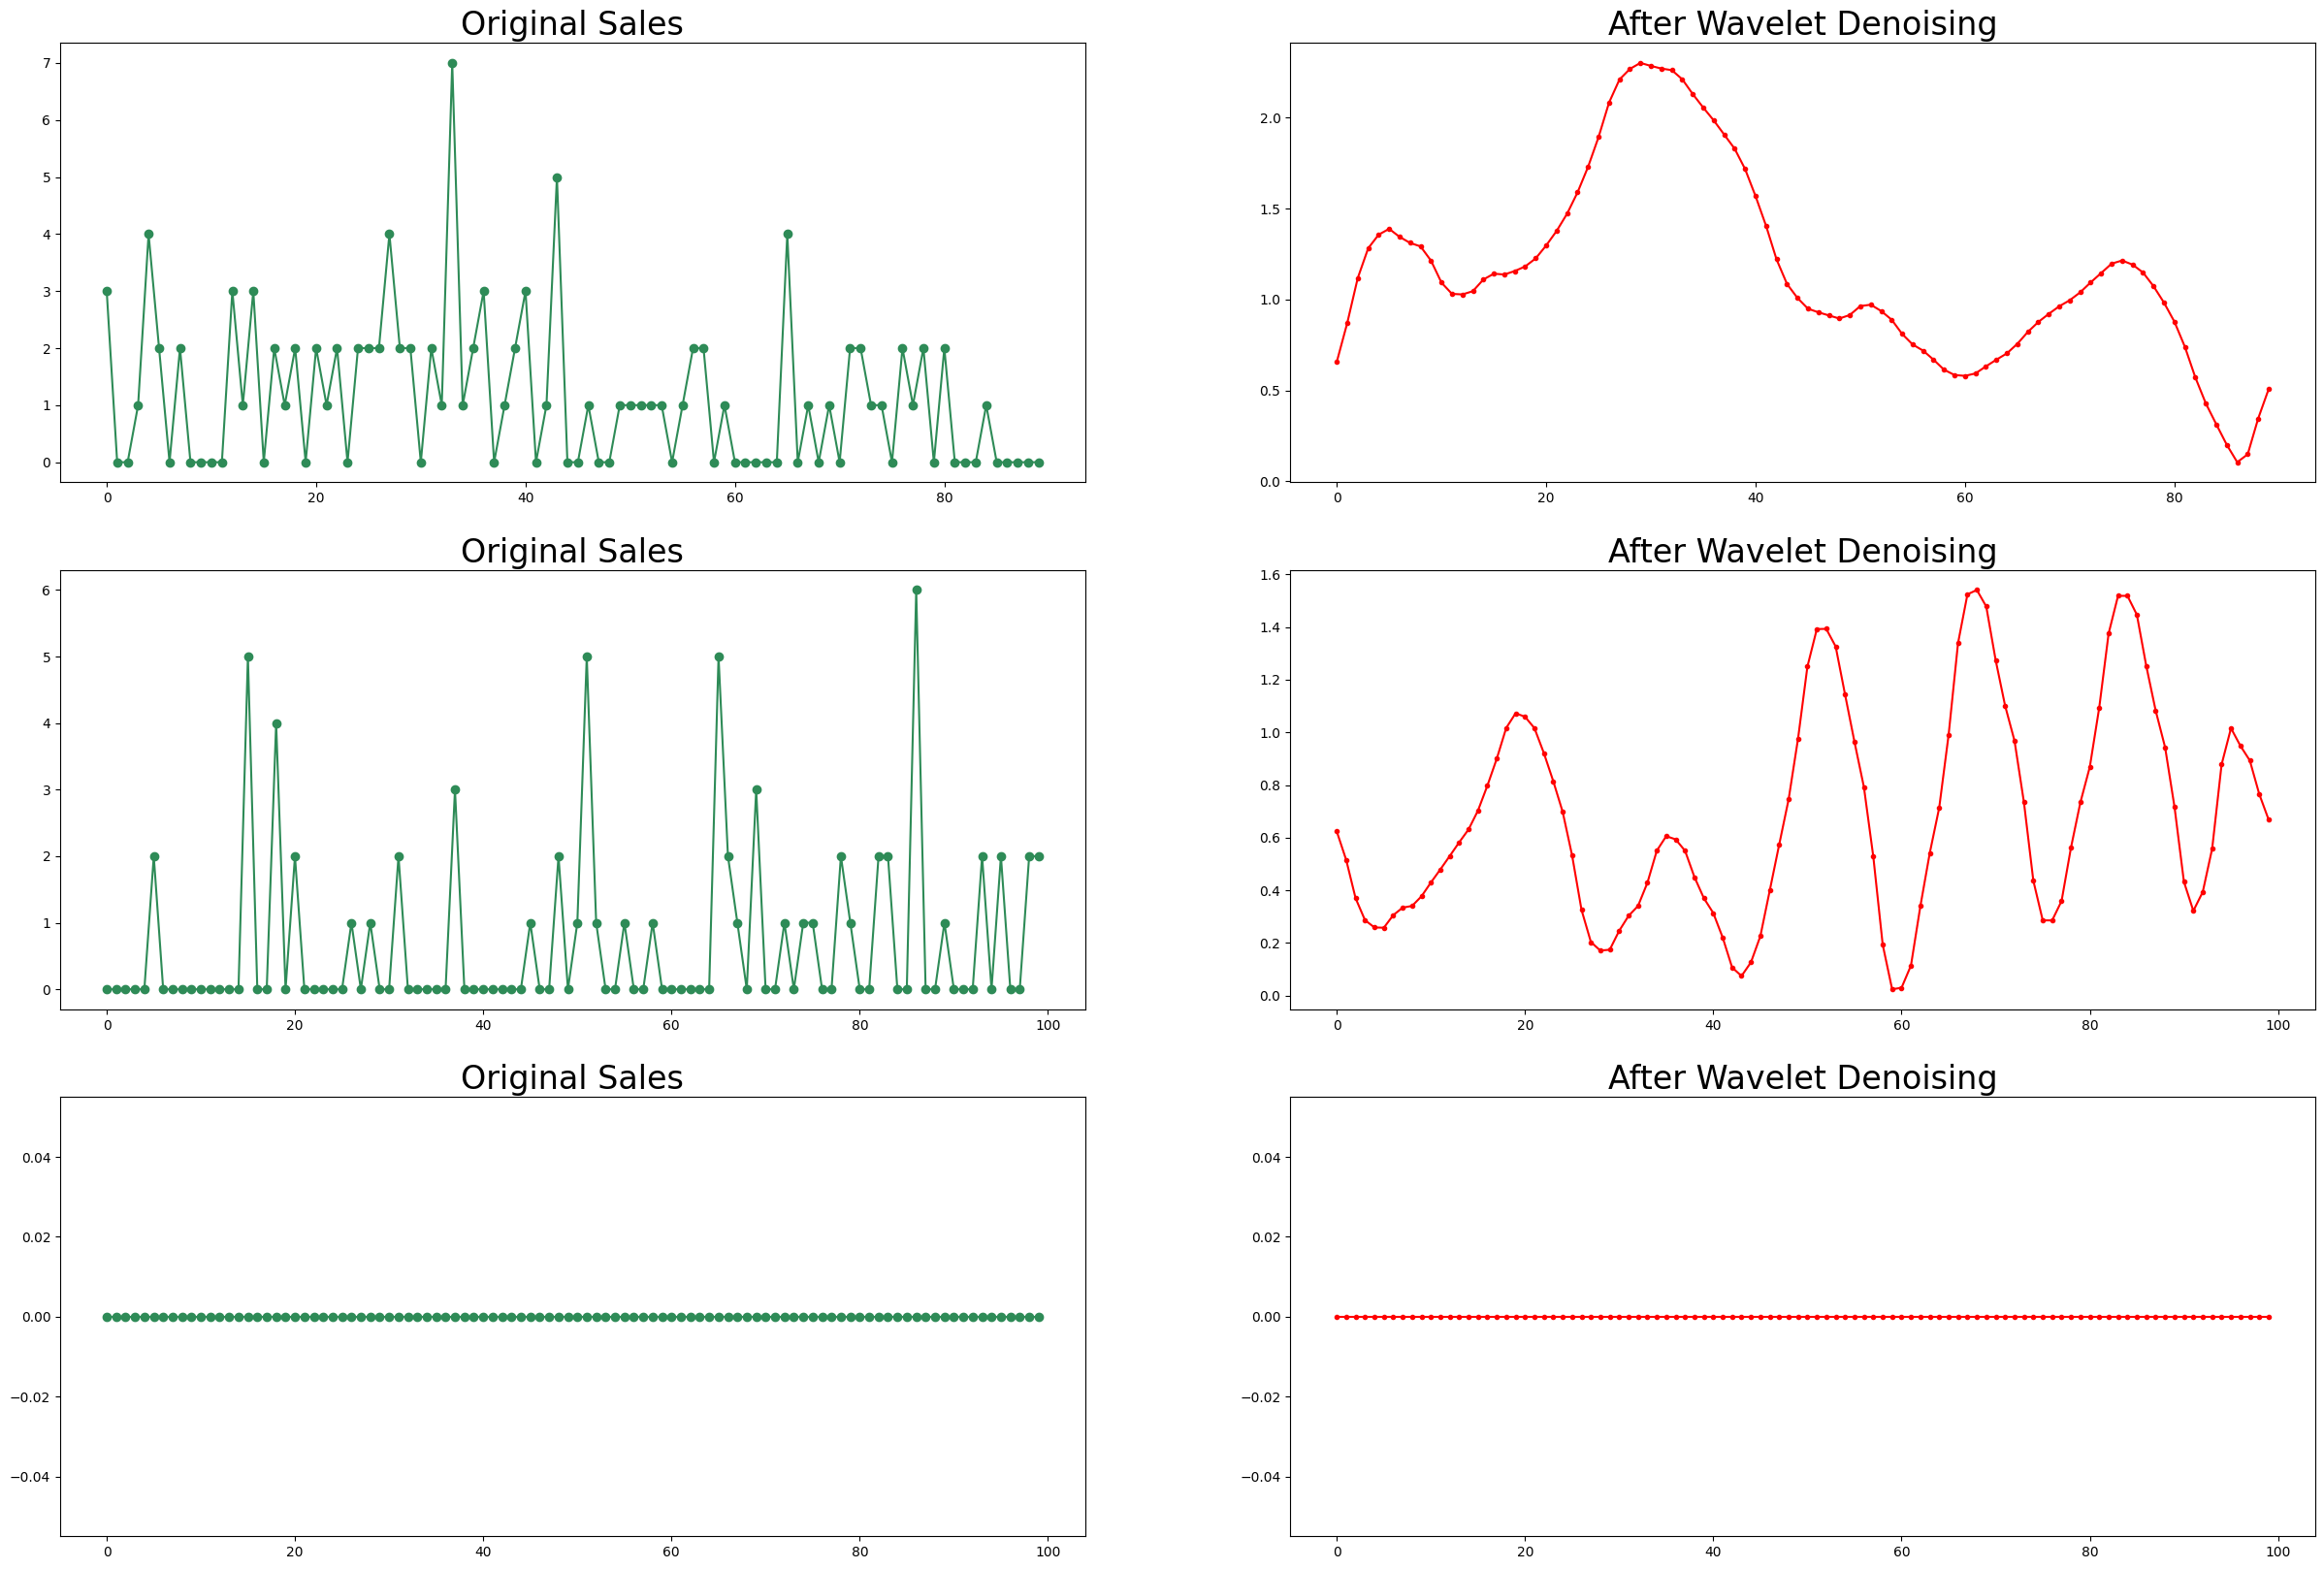

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(30, 20))

ax[0, 0].plot(x_1, color='seagreen', marker='o')
ax[0, 0].set_title('Original Sales', fontsize=24)
ax[0, 1].plot(y_w1, color='red', marker='.')
ax[0, 1].set_title('After Wavelet Denoising', fontsize=24)

ax[1, 0].plot(x_2, color='seagreen', marker='o')
ax[1, 0].set_title('Original Sales', fontsize=24)
ax[1, 1].plot(y_w2, color='red', marker='.')
ax[1, 1].set_title('After Wavelet Denoising', fontsize=24)

ax[2, 0].plot(x_3, color='seagreen', marker='o')
ax[2, 0].set_title('Original Sales', fontsize=24)
ax[2, 1].plot(y_w3, color='red', marker='.')
ax[2, 1].set_title('After Wavelet Denoising', fontsize=24)

plt.show()